# GCN Code

### Latex Macros
$\newcommand{\Re}[1]{{\mathbb{R}^{{#1}}}}
\newcommand{\Rez}{{\mathbb{R}}}$

# GNN_torch_edge_attrib_update_torch.ipynb (2022-03-07)
* Based on First_GNN_torch_implementation
* Eventually implement edge and graph embeddings in addition node embddings
* Continue to refacdtor the code
* Starting from First_GNN_torch_implementation.ipynb, transform it to a version using using aggregation and update operators. 
* This is message passing approach.
* The code will still handle the Karate Club Graph
* Use a function library just for the Karate Club Graph dataset. 
* This library will later be generalized to handle a wider set of data. 
* Eventually, we will use the PyGeometric, but there is lots to learn before that point. 
* I am adding edge attributes, which is synthetic. 
* [Torch tutorial](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html)

In [1]:
%load_ext autoreload
%autoreload 2

In [58]:
import torch
import torch.sparse as tsp
# help(torch.sparse)
from torch import tensor
import torch_sparse as t_sp
#from torchsummary import summary
import tqdm.auto
from tqdm import tqdm
import os
from collections import defaultdict
import spectral_function_library as speclib
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import karate_function_library as karate
import model_node_edge_attributes_library as modeledgelib

# Test COO sparse matrices
* There are two auxiliary arrays for each sparse matrix
* Docs: https://pytorch.org/docs/stable/sparse.html

In [6]:
# Test sparse matrix
# https://pytorch.org/docs/stable/sparse.html
"""
 A =  1 0 5
      3 2 0
"""

IA = [0,0,1,1]   # row number of non-zero elements
JA = [0,2,0,1]   # column number of non-zero elements
VA = tensor([1.,5.,3.,2.]) # non-zero values
mA = 2  # 2 rows
nA = 3  # 3 columns
indexA = tensor([IA, JA])

"""
 B =  1 0 
      3 2
      0 3
"""

IB = [0,1,1,2]
JB = [0,0,1,1]
VB = tensor([1.,3.,2.,3.])  # values
mB = 3  # 3 rows
nB = 2  # 2 columns
indexB = tensor([IB, JB])

C = tensor([[2., 3.], [4., 5.]])  # 2,2

# Objective: multipley B @ C (Matrix-matrix multiplication)

# help(torch.sparse_coo_tensor)
# Supposedly, using CSR format is faster than COO format, on the CPU
# However, CSR has no GPU implementation
# COO is the simplest format to understand

# Create a sparse array in COO format
cooA = torch.sparse_coo_tensor(indexA, VA, [mA, nA])
cooB = torch.sparse_coo_tensor(indexB, VB, [mB, nB])
cooA

tensor(indices=tensor([[0, 0, 1, 1],
                       [0, 2, 0, 1]]),
       values=tensor([1., 5., 3., 2.]),
       size=(2, 3), nnz=4, layout=torch.sparse_coo)

In [11]:
# Convert from a sparse format to a dense format
denseA = cooA.to_dense()
denseB = cooB.to_dense()
print(denseA.shape, denseB.shape, C.shape)
print(denseB)

torch.Size([2, 3]) torch.Size([3, 2]) torch.Size([2, 2])
tensor([[1., 0.],
        [3., 2.],
        [0., 3.]])


In [12]:
# Sparse @ Dense matrix-matrix multiplication is allowed
# Dense @ Sparse is not allowed (routines not implemented, reasons unknwown

# Dense @ Dense multiplication
BmmC = denseB @ C
print("B @ C = ", BmmC)  

B @ C =  tensor([[ 2.,  3.],
        [14., 19.],
        [12., 15.]])


In [9]:
# Dense multiplied by dense matrix
C @ denseA

tensor([[11.,  6., 10.],
        [19., 10., 20.]])

In [10]:
# Dense @ Sparse does not work
t_sp.matmul(C, cooA)

AttributeError: 'Tensor' object has no attribute 'csr'

## sparse @ sparse is harder to do. 
* Do not know how to do it. 

## dense @ sparse not supported by torch

In [14]:
### We use the famous 'Karate Club' network as a test case. Our task is to
### predict the community to which each node belongs; formally, this would be
### called transductive binary node classification.

G = nx.karate_club_graph()

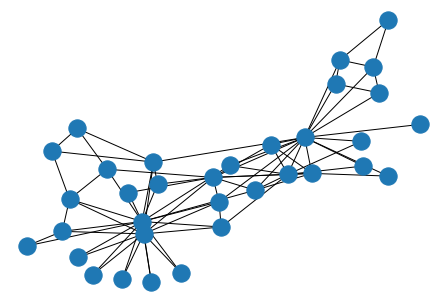

In [17]:
# Draw the graph multiple times. Different representation might give different impressions. 
# Therefore, what the graph looks like is very important.  There is no recipe to create
# a good plot.
nx.draw(G)

Mr. Hi
Mr. Hi
Mr. Hi
Mr. Hi
Mr. Hi
Mr. Hi
Mr. Hi
Mr. Hi
Mr. Hi
Officer


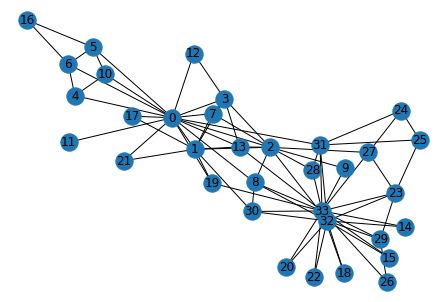

In [18]:
# Color the nodes
# Note the metadata
G.nodes[3]

# Assign node positions
pos = nx.drawing.layout.spring_layout(G)
nx.drawing.draw(G, pos=pos, with_labels=True)

# Create a color_array
for i in range(10):
    print(G.nodes[i]['club'])

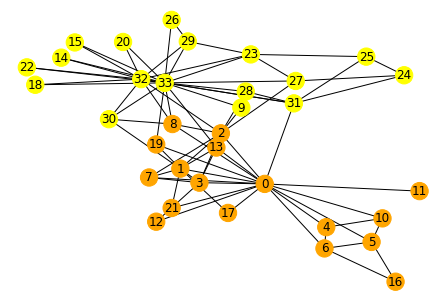

In [35]:
colors = []
for i in range(len(G.nodes())):
    if G.nodes[i]['club'] == 'Officer':
        colors.append('yellow')
    else:
        colors.append('orange')

#pos = nx.drawing.layout.shell_layout(G)  # not as good. Labels not separated.
pos = nx.drawing.layout.spring_layout(G)  # Labels separate well.
nx.drawing.draw(G, pos=pos, with_labels=True, node_color=colors)

# Choose drawing approach carefully. Best choices are problem-dependent. 

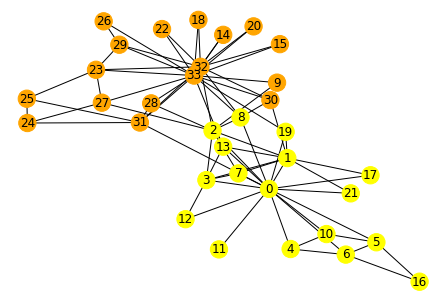

In [39]:
# Once a task created, create a new function in a library file. 
karate.drawOriginalGraph(G)

# Features
* Add features on nodes and edges. 
* Each feature column is a Gaussian of fixed mean and standard deviation.
* In math notation, the node feature matrix is $X\in \Re{N\times d}$, where $x_{i,j} \sim N(\mu, \sigma)$
* The edge feature matrix is $X^E\in \Re{N\times f}$, where $x^E_{i,j} \sim N(\mu_E, \sigma_E)$. 

In [41]:
# add nb_features, node_metadata to G
karate.add_gaussian_features(G, node_means=[0.0, 1.5], node_stds=(1, 1), 
                             nb_node_features=16, nb_edge_features=8)

# Associated Matrices
$A \in \Re{N\times N}$ is the adjacency matrix
* Undirected graph ==> $A$ is symmetric
* Directed graph ==> $A$ is non-symmetric
* Multigraph ==> $A$ is typically weighted with $A(i,j)$ the number of edgeds between $i$ and $j$

In [56]:
# Define A, B, and various normalizations and attach them to G
karate.update_associated_matrices(G)

G.B:  torch.Size([78, 34])
G.B.transp:  torch.Size([34, 78])


/Users/erlebach/src/2022/graphs/Advanced_Grad_Seminar_GNN/node_edge_embeddings_2022-03-20/karate_function_library.py:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  G.An = torch.tensor(G.Dinvsq @ G.An @ G.Dinvsq).detach.float() # symmetric normalization


# Plot Metadata histograms

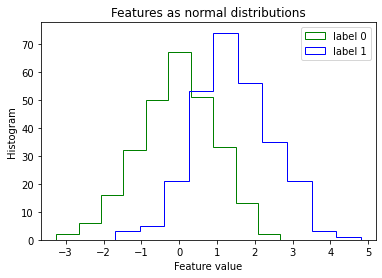

In [23]:
karate.plot_metadata(G)

# GNN layer: Linear model is 
$$ H^{n+1} = A H^n W $$
where $H\in \Re{N\times d}$, $A\in\Re{N\times N}$, and $W\in\Re{d\times d}$ and $d$ is the number of features. In our synthetic example, we have 16 features, one label. 

We have added edge features. The goal is to make the edge features interact with the node features and update them to convergence, and link them to downstream layers of the Neural Network and eventually to a cost function. 

Model has three internal functions (following general formulation in paper by Battaglia): 
* update_edges(): linear combination of edge features and node features at edge extremeties
* edges_to_nodes: transfer features from the edges back to the nodes: linear combination of edge features on edges connected to the nodes. 
* update_nodes: linear combination of node features and edge feature transferred to the node

In [190]:
## Test the GNN model on its own
model = modeledgelib.GNNNodesEdges(G)

# show model.W0, and notice "requires_grad=True"

## Observations
By default, the features are two normal distributions (16 values per node, so there are 16 features). 
One Gaussian is placed over its appropriate label (there are two labels). With 16 features, I experiment with the fraction of nodes in the training set. I choose a fraction `frac_train` of the nodes as the training set. 
Edges features are also two Gaussians. In practice, they can be anything, continuous or discrete. 

In [191]:
# 0: training set (50%); 1: testing set (50%)
# mask = torch.from_numpy(np.random.randint(0, 2, H0.shape[0]))

def setup_training(model, frac_train=0.5, lr=0.001):
    # Random choice 0/1: 0 is for training node, 1 is for testing node
    mask = torch.from_numpy(
        np.random.choice(2, G.nb_nodes, p=[frac_train, 1.0 - frac_train])
    )

    loss_fn = modeledgelib.BinaryCrossEntropyLoss(mask)

    # optimizer = torch.optim.SGD(model.parameters(), lr=1.e-3)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    return loss_fn, optimizer, mask

# New model
* My new model, which takes edge features into account. 
* The model does NOT create edge embeddings

In [216]:
model = modeledgelib.myGCN(G)

loss_fn, optimizer, mask = setup_training(model, frac_train=0.55, lr=0.001)
model.optimizer = optimizer
model.loss_fn = loss_fn

In [217]:
# Train the network
# If this is run multiple times, the previous simulation is continued
losses, accuracy_count, node_embeddings, edge_embeddings = \
    modeledgelib.new_train(G, model, mask, loss_fn, optimizer, nb_epochs=2000)

/Users/erlebach/src/2022/graphs/Advanced_Grad_Seminar_GNN/node_edge_embeddings_2022-03-20/model_node_edge_attributes_library.py:186: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y = G.labels
/Users/erlebach/src/2022/graphs/Advanced_Grad_Seminar_GNN/node_edge_embeddings_2022-03-20/model_node_edge_attributes_library.py:187: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [218]:
losses[::20], losses[-10:], len(losses)

([25.650577545166016, 12.126408576965332, 10.82723617553711, 9.87907600402832],
 [9.536985397338867,
  9.47263240814209,
  9.406203269958496,
  9.3356294631958,
  9.263948440551758,
  9.189140319824219,
  9.111944198608398,
  9.032403945922852,
  8.950510025024414,
  8.865885734558105],
 76)

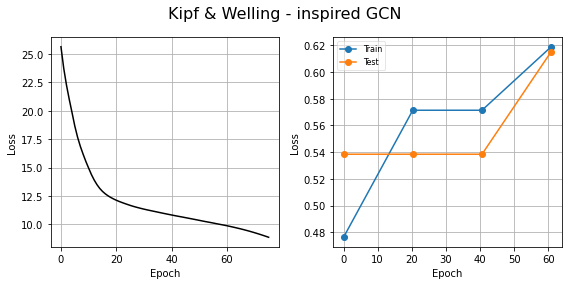

y.shape:  (76, 2)


In [219]:
fig, axes = plt.subplots(1, 2, figsize=(8,4))
plt.suptitle("Kipf & Welling - inspired GCN", fontsize=16)
speclib.plot_one_curve(axes[0], losses, xlabel='Epoch', ylabel='Loss', style='-', title='')

y = np.asarray([v for k,v in accuracy_count.items()]).T  # shape: [N, 2]  
x = np.linspace(0, y.shape[0]*1, y.shape[0])
speclib.plot_multi_curves(axes[1], x[::20], y[::20,:], xlabel='Epoch', ylabel='Loss', title='', labels=['Train', 'Test'])

plt.tight_layout()
plt.show()
print("y.shape: ", y.shape)